# TC 5033
## Deep Learning
## Fully Connected Deep Neural Networks

#### Activity 1b: Implementing a Fully Connected Network for Kaggle ASL Dataset

- Objective

The aim of this part of the activity is to apply your understanding of Fully Connected Networks by implementing a multilayer network for the [Kaggle ASL (American Sign Language) dataset](https://www.kaggle.com/datasets/grassknoted/asl-alphabet). While you have been provided with a complete solution for a Fully Connected Network using Numpy for the MNIST dataset, you are encouraged to try to come up with the solution.

- Instructions

    This activity requires submission in teams of 3 or 4 members. Submissions from smaller or larger teams will not be accepted unless prior approval has been granted (only due to exceptional circumstances). While teamwork is encouraged, each member is expected to contribute individually to the assignment. The final submission should feature the best arguments and solutions from each team member. Only one person per team needs to submit the completed work, but it is imperative that the names of all team members are listed in a Markdown cell at the very beginning of the notebook (either the first or second cell). Failure to include all team member names will result in the grade being awarded solely to the individual who submitted the assignment, with zero points given to other team members (no exceptions will be made to this rule).

    Load and Preprocess Data: You are provided a starter code to load the data. Be sure to understand the code.

    Review MNIST Notebook (Optional): Before diving into this activity, you have the option to revisit the MNIST example to refresh your understanding of how to build a Fully Connected Network using Numpy.

    Start Fresh: Although you can refer to the MNIST solution at any point, try to implement the network for the ASL dataset on your own. This will reinforce your learning and understanding of the architecture and mathematics involved.

    Implement Forward and Backward Pass: Write the code to perform the forward and backward passes, keeping in mind the specific challenges and characteristics of the ASL dataset.
    
     Design the Network: Create the architecture of the Fully Connected Network tailored for the ASL dataset. Choose the number of hidden layers, neurons, and hyperparameters judiciously.

    Train the Model: Execute the training loop, ensuring to track performance metrics such as loss and accuracy.

    Analyze and Document: Use Markdown cells to document in detail the choices you made in terms of architecture and hyperparameters, you may use figures, equations, etc to aid in your explanations. Include any metrics that help justify these choices and discuss the model's performance.  

- Evaluation Criteria

    - Code Readability and Comments
    - Appropriateness of chosen architecture and hyperparameters for the ASL dataset
    - Performance of the model on the ASL dataset (at least 70% acc)
    - Quality of Markdown documentation

- Submission

Submit this Jupyter Notebook in canvas with your complete solution, ensuring your code is well-commented and includes Markdown cells that explain your design choices, results, and any challenges you encountered.


In [93]:
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import os

%load_ext autoreload
%autoreload 2
#################################
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
DATA_PATH = './data/asl_data'
train_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_train.csv'))
valid_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_valid.csv'))

In [95]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,12,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


### Importar Images

In [96]:
y_train = np.array(train_df['label'])
y_val = np.array(valid_df['label'])
del train_df['label']
del valid_df['label']
x_train = train_df.values.astype(np.float32)
x_val = valid_df.values.astype(np.float32)

In [97]:
def split_val_test(x, y, pct=0.5, shuffle=True):
    '''
    Create a function that will allow you to split the previously loaded validation set
    into valition and test.
    '''
    """
    Split the validation set into validation and test subsets.

    Parameters:
    x (array-like): Features of the dataset.
    y (array-like): Labels corresponding to the features.
    pct (float): Percentage of the data to allocate for the test set (default is 0.5).
    shuffle (bool): Whether to shuffle the dataset before splitting (default is True).

    Returns:
    tuple: (x_val, y_val, x_test, y_test)
        - x_val: Features for the validation subset.
        - y_val: Labels for the validation subset.
        - x_test: Features for the test subset.
        - y_test: Labels for the test subset.
    """
    if shuffle:
        indices = np.arange(len(x))
        np.random.shuffle(indices)
        x = np.array(x)[indices]
        y = np.array(y)[indices]

    split_idx = int(len(x) * (1 - pct))

    x_val, x_test = x[:split_idx], x[split_idx:]
    y_val, y_test = y[:split_idx], y[split_idx:]

    return x_val, y_val, x_test, y_test

In [98]:
x_val, y_val, x_test, y_test = split_val_test(x_val, y_val)

In [99]:
### The following
alphabet=list(string.ascii_lowercase)
alphabet.remove('j')
alphabet.remove('z')
print(len(alphabet))

24


### Normalise

In [100]:
def normalise(x_mean, x_std, x_data):
    return (x_data - x_mean) / x_std

x_mean = x_train.mean()
x_std = x_train.std()

x_train = normalise(x_mean, x_std, x_train)
x_val = normalise(x_mean, x_std, x_val)
x_test = normalise(x_mean, x_std, x_test)

### Graficar muestras

In [101]:
def plot_image(data, labels, index):
    '''
    Plots a single 28x28 grayscale image with the title that indicates the letter it represents.
    Parameters:
    - data: Dataset containing the image data (e.g., x_train, x_val)
    - labels: Dataset containing the corresponding labels (e.g., y_train, y_val)
    - index: Index of the image in the dataset
    '''
    # Reshape the image data back into 28x28 format for visualization
    image = data[index].reshape(28, 28)

    # Convert the label to ASCII (A-I: 65-73, K-Y: 75-89 in ASCII)
    label = labels[index]
    if label >= 9:  # Adjust labels for J (label 9 and above)
        ascii_letter = chr(label + 66)  # Skip J (add 1 to adjust for the missing J)
    else:
        ascii_letter = chr(label + 65)  # Labels A-I remain unchanged

    # Plot the image with the corresponding label as title
    plt.imshow(image, cmap='gray')
    plt.title(f"This is the letter: {ascii_letter}")
    plt.axis('off')  # Hide axes for cleaner visualization
    plt.show()

### Ecuaciones para nuestro modelo


$$z^1 = W^1 X + b^1$$

$$a^1 = ReLU(z^1) $$

$$z^2 = W^2 a^1 + b^2$$

$$\hat{y} = \frac{e^{z^{2_k}}}{\sum_j{e^{z_j}}}$$


$$ \mathcal{L}(\hat{y}^{i}, y^{i}) =  - y^{i}  \ln(\hat{y}^{i}) = -\ln(\hat{y}^i)$$


$$ \mathcal{J}(w, b) =  \frac{1}{num\_samples} \sum_{i=1}^{num\_samples}-\ln(\hat{y}^{i})$$

### Funciones adicionales

#### Mini batches

In [102]:
def create_minibatches(mb_size, x, y, shuffle = True):
    '''
    x  #muestras, 784
    y #muestras, 1
    '''
    assert x.shape[0] == y.shape[0], 'Error en cantidad de muestras'
    total_data = x.shape[0]
    if shuffle:
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

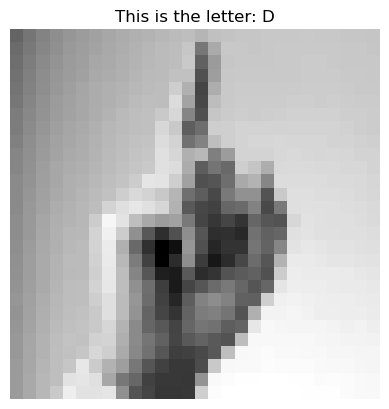

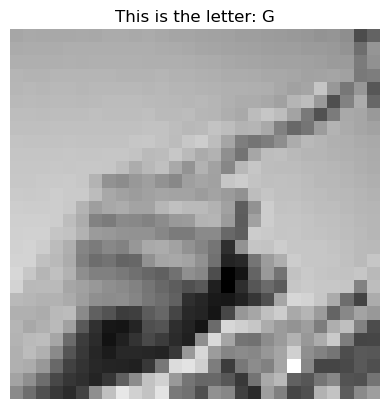

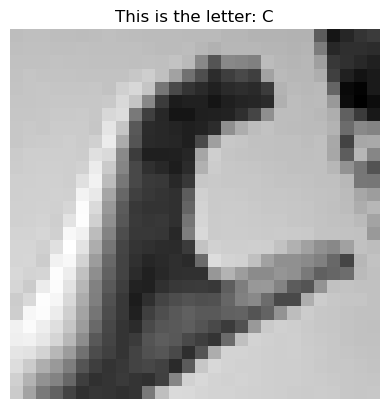

In [103]:
for i in range(0,3):
    plot_image(x_train, y_train, i)

## Nuestra clase Linear, ReLU y Sequential

In [104]:
class np_tensor(np.ndarray): pass

###  Clase Linear

In [105]:
class Linear():
    def __init__(self, input_size, output_size):
        '''
        Init parameters utilizando Kaiming He
        '''
        self.W = (np.random.randn(output_size, input_size) / np.sqrt(input_size/2)).view(np_tensor)
        self.b = (np.zeros((output_size, 1))).view(np_tensor)
    def __call__(self, X): # esta el foward de la clase lineal
        Z = self.W @ X + self.b
        return Z
    def backward(self, X, Z):
        X.grad = self.W.T @ Z.grad
        self.W.grad = Z.grad @ X.T
        self.b.grad = np.sum(Z.grad, axis = 1, keepdims=True)


### Clase ReLU

In [106]:
class ReLU():
    def __call__(self, Z):
        return np.maximum(0, Z)
    def backward(self, Z, A):
        Z.grad = A.grad.copy()
        Z.grad[Z <= 0] = 0

### Clase Sequential

In [107]:
class Sequential_layers():
    def __init__(self, layers):
        '''
        layers - lista que contiene objetos de tipo Linear, ReLU
        '''
        self.layers = layers
        self.x = None
        self.outputs = {}
    def __call__(self, X):
        self.x = X
        self.outputs['l0'] = self.x
        for i, layer in enumerate(self.layers, 1):
            self.x = layer(self.x)
            self.outputs['l'+str(i)]=self.x
        return self.x
    def backward(self):
        for i in reversed(range(len(self.layers))):
            self.layers[i].backward(self.outputs['l'+str(i)], self.outputs['l'+str(i+1)])
    def update(self, learning_rate = 1e-3):
        for layer in self.layers:
            if isinstance(layer, ReLU): continue
            layer.W = layer.W - learning_rate * layer.W.grad
            layer.b = layer.b - learning_rate * layer.b.grad
    def predict(self, X):
        return np.argmax(self.__call__(X))

### Cost Function

In [108]:
def softmaxXEntropy(x, y):
    batch_size = x.shape[1]
    exp_scores = np.exp(x)
    probs = exp_scores / exp_scores.sum(axis = 0)
    preds = probs.copy()
    # Costo
    y_hat = probs[y.squeeze(), np.arange(batch_size)]
    cost = np.sum(-np.log(y_hat)) / batch_size
    # Calcular gradientes
    probs[y.squeeze(), np.arange(batch_size)] -= 1 #dl/dx
    x.grad = probs.copy()

    return preds, cost

### Loop de entrenamiento

In [113]:
def train(model, epochs, mb_size=128, learning_rate = 1e-3):
    for epoch in range(epochs):
        for i, (x, y) in enumerate(create_minibatches(mb_size, x_train, y_train)):
            scores = model(x.T.view(np_tensor))
            _, cost = softmaxXEntropy(scores, y)
            model.backward()
            model.update(learning_rate)
        print(f'Epoch {epoch+1}/{epochs}, cost: {cost}, accuracy: {accuracy(x_val, y_val, model, mb_size)}')

    final_accuracy = accuracy(x_val, y_val, model, mb_size)
    return final_accuracy

### Create your model and train it

In [110]:
def accuracy(x, y, model, mb_size):
    correct = 0
    total = 0
    for i, (x, y) in enumerate(create_minibatches(mb_size, x, y)):
        pred = model(x.T.view(np_tensor))
        correct += np.sum(np.argmax(pred, axis=0) == y.squeeze())
        total += pred.shape[1]
    return correct/total

### Test your model on Random data from your test set

In [114]:
import itertools
def grid_search_train(train, nodes, epochs, mb_size, learning_rate):
    param_grid = list(itertools.product(nodes, epochs, mb_size, learning_rate))

    best_model = None
    best_accuracy = 0
    best_params = None

    for (nodes ,epochs, mb_size, learning_rate) in param_grid:
        print(f"Training with params:nodes={nodes}, epochs={epochs}, mb_size={mb_size}, learning_rate={learning_rate}")
        model=Sequential_layers([Linear(784, nodes), ReLU(), Linear(nodes, 24)])
        accuracy = train(model, epochs, mb_size, learning_rate)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = (nodes, epochs, mb_size, learning_rate)
            best_model = model

        print(f"Accuracy: {accuracy}, Best Accuracy: {best_accuracy}")

    print(f"Best parameters:nodes={best_params[0]}, epochs={best_params[1]}, mb_size={best_params[2]}, learning_rate={best_params[3]}")
    return best_model, best_params, best_accuracy

In [ ]:
nodes = [64, 128, 256, 512]
epochs = [10, 20, 30]
mb_size = [16, 32, 64, 128]
learning_rate = [0.001, 0.002, 0.005, 0.007, 0.01]

best_model, best_params, best_accuracy = grid_search_train(train, nodes, epochs, mb_size,learning_rate)

Training with params:nodes=64, epochs=10, mb_size=16, learning_rate=0.001
Epoch 1/10, cost: 0.13793085500573712, accuracy: 0.7571109871723368
Epoch 2/10, cost: 0.1258491071842858, accuracy: 0.762409369771333
Epoch 3/10, cost: 0.030289909707473375, accuracy: 0.7674288901282766
Epoch 4/10, cost: 0.018566759469110183, accuracy: 0.77356385945343
Epoch 5/10, cost: 0.024064964260362774, accuracy: 0.7730061349693251
Epoch 6/10, cost: 0.006257803504498663, accuracy: 0.7691020635805912
Epoch 7/10, cost: 0.019113735406254436, accuracy: 0.7718906860011154
Epoch 8/10, cost: 0.010345420214776848, accuracy: 0.7702175125488009
Epoch 9/10, cost: 0.004712342275196931, accuracy: 0.7749581706636921
Epoch 10/10, cost: 0.003901348712303711, accuracy: 0.7738427216954824
Accuracy: 0.7738427216954824, Best Accuracy: 0.7738427216954824
Training with params:nodes=64, epochs=10, mb_size=16, learning_rate=0.002
Epoch 1/10, cost: 0.14418447652009697, accuracy: 0.7200223089793641
Epoch 2/10, cost: 0.026438743508469

C:\Users\alexa\AppData\Local\Temp\ipykernel_1360\1990919710.py:8: RuntimeWarning: divide by zero encountered in log
  cost = np.sum(-np.log(y_hat)) / batch_size
C:\Users\alexa\AppData\Local\Temp\ipykernel_1360\1990919710.py:3: RuntimeWarning: overflow encountered in exp
  exp_scores = np.exp(x)
C:\Users\alexa\AppData\Local\Temp\ipykernel_1360\1990919710.py:4: RuntimeWarning: invalid value encountered in divide
  probs = exp_scores / exp_scores.sum(axis = 0)


Epoch 1/10, cost: nan, accuracy: 0.04656999442275516
Epoch 2/10, cost: nan, accuracy: 0.04656999442275516
Epoch 3/10, cost: nan, accuracy: 0.04656999442275516
Epoch 4/10, cost: nan, accuracy: 0.04656999442275516
Epoch 5/10, cost: nan, accuracy: 0.04656999442275516
Epoch 6/10, cost: nan, accuracy: 0.04656999442275516
Epoch 7/10, cost: nan, accuracy: 0.04656999442275516
Epoch 8/10, cost: nan, accuracy: 0.04656999442275516
Epoch 9/10, cost: nan, accuracy: 0.04656999442275516
Epoch 10/10, cost: nan, accuracy: 0.04656999442275516
Accuracy: 0.04656999442275516, Best Accuracy: 0.7875069715560513
Training with params:nodes=64, epochs=10, mb_size=128, learning_rate=0.001
Epoch 1/10, cost: 0.17462055294150153, accuracy: 0.7105409927495817
Epoch 2/10, cost: 0.04269725089865439, accuracy: 0.7401003904071388
Epoch 3/10, cost: 0.02860915381833175, accuracy: 0.745398773006135
Epoch 4/10, cost: 0.020251406544298082, accuracy: 0.7448410485220301
Epoch 5/10, cost: 0.012470032730857632, accuracy: 0.74456

In [116]:
print(f"Best Accuracy: {best_accuracy} with parameters: {best_params}")

Best Accuracy: 0.8006134969325154 with parameters: (64, 5, 64, 0.005)
